Introduction to PyTorch on Google Colaboratory  
===============================================

Copyright (c) 2019-2024, NECOTIS  (All rights reserved.)

Authors: Ismael Balafrej, Ahmad El Ferdaoussi, Alexis MélotL, Arnaud Yarga


Google Colab
============

As defined by Google: Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud. With Colaboratory you can write and execute code, save and share your analyses, and access powerful computing resources, all for free from your browser.

Your jupyter notebooks can be uploaded directly using the interface. It runs on the cloud and it's entirely free (or at least for the moment, so let's get the most out of it!). All you need is a Google account (typically Gmail) since your notebooks are saved directly in your Google Drive.

In [ ]:
# Most python packages for ML and data processing in general are pre-installed
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch

In [ ]:
# In the upper right corner, you can see the physical limits in disk space and ram, normally it's big enough for most application
!free -h
!df -h /

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.3Gi       5.9Gi       1.0Mi       5.5Gi        11Gi
Swap:             0B          0B          0B
Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   33G   81G  29% /


In [ ]:
# Most importantly, you have access to a fairly new GPU for high parallelisation processing
!nvidia-smi

Mon Nov 11 22:10:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Keep it mind that Colab is free to use for research purposes. You have up to 12h of continuous usage so this should be more than good enough for this problem.
You **cannot** use it for cryptocurrency mining, prime factorization, or other misuse.

PyTorch
=======
As defined by Wikipedia: PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing. It is primarily developed by Facebook's AI Research Group. It is free and open-source software released under the Modified BSD license.

Although the official name is PyTorch, the package is referred to as torch. You can install it on your machine with a `pip install torch` or `conda install -c pytorch pytorch`.

You can find PyTorch tutorials at https://pytorch.org/tutorials/ and the documentation at https://pytorch.org/docs/stable/index.html

In [ ]:
torch.manual_seed(0) # As always, we can set the seed for reproductibility
np.random.seed(0)

# As it's core, pytorch is very similar to numpy. The major distinction is that you can select a device and transfer between devices.

# Here we select the device based on what is available. If we have a gpu access, the device will be the GPU, otherwise, we'll run the code on CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Pytorch is fairly agnostic on whether you use a GPU or a CPU when you write python code. The only thing you have to keep in mind
# is to keep your operation on the same device

In [ ]:
# Another small distinction is that in numpy, the main data structure is called an array while in pytorch it's called a tensor
X_np = np.ones((100, 100))
X_torch = torch.ones((100, 100), device=device)

In [ ]:
# While the API is mostly the same, the underlying types are not always identical
# But for most cases, it doesn't matter
print(X_np.shape)
print(X_torch.shape)
print(X_np.ndim)
print(X_torch.ndim)

(100, 100)
torch.Size([100, 100])
2
2


In [ ]:
# You can also convert seamless between numpy arrays and pytorch tensors if need be
# Although, since numpy is CPU only, you have to transfer the memory to the RAM first
X_torch_to_numpy = X_torch.cpu().numpy()
np.all(X_np == X_torch_to_numpy)

True

In [ ]:
# In some cases, when doing gradient based methods you even have to "detach"
# This is because pytorch, like tensorflow, can automatically compute the gradient for you
# You can specify this at variable initialization
X_torch = torch.ones((100, 100), device=device, requires_grad=True)
print(X_torch.detach().cpu().numpy().shape) # Here we need to detach the tensor from the automatic gradient calculations in order to convert it

(100, 100)


In [ ]:
# That's the reverse operation, so from numpy to pytorch
# By default, the tensor will be converted to the CPU device
# But since we are using a GPU here, the "to" method can
# transfer the memory to the GPU
X_np = np.random.random((1000, 1000))
X_torch = torch.from_numpy(X_np).to(device)

In [ ]:
# More examples of the similarities between numpy and pytorch

X_torch[0:100] *= 5
X_np[0:100] *= 5

X_torch = X_torch.T
X_np = X_np.T

amax_torch = torch.argmax(X_torch, axis=0)
amax_np = np.argmax(X_np, axis=0)
assert(np.all(amax_torch.cpu().numpy() == amax_np))

As mentioned before, pytorch can be GPU accelerated. To see why this is useful, we can do a simple operation that is highly parallelizable like a matrix multiplication two hunded times (And we normalize to not overflow):

In [ ]:
start = time.time()

for _ in range(200):
    X_torch = torch.matmul(X_torch, X_torch)
    X_torch /= torch.max(X_torch)

print("Execution took %.3f seconds" % (time.time() - start))

Execution took 0.189 seconds


In [ ]:
start = time.time()

for _ in range(200):
    X_np = np.matmul(X_np, X_np)
    X_np /= np.max(X_np)

print("Execution took %.3f seconds" % (time.time() - start))

Execution took 11.814 seconds


Let's now explore a little bit more the autograd features of pytorch, which numpy doesn't have

In [ ]:
# Let's create a toy dataset of two overlaping normal random points
N = 500 # number of points per class
X_1 = torch.distributions.normal.Normal(1, 1.).sample((N,)).float().to(device)
X_2 = torch.distributions.normal.Normal(3, 1).sample((N,)).float().to(device)
y_1 = torch.zeros(N, device=device) # Label 1 = 0
y_2 = torch.ones(N, device=device) # Label 2 = 1
X = torch.cat([X_1, X_2], dim=0) # Concatenate the data
y = torch.cat([y_1, y_2], dim=0) # And the labels
random_indexes = torch.randperm(2*N) # Randomly permute the array
X = X[random_indexes].view(-1, 1) # View here will convert a (N,) shaped array to a (N, 1) shaped matrix
y = y[random_indexes].view(-1, 1)

# Transform the label into one-hot encoding, 0 => [1, 0] and 1 => [0, 1]
oh_y = torch.zeros(y.shape[0], 2, device=device)
oh_y = oh_y.scatter(1, y.long(), 1);

# Normalize the input
X = (X - torch.mean(X)) / torch.std(X)

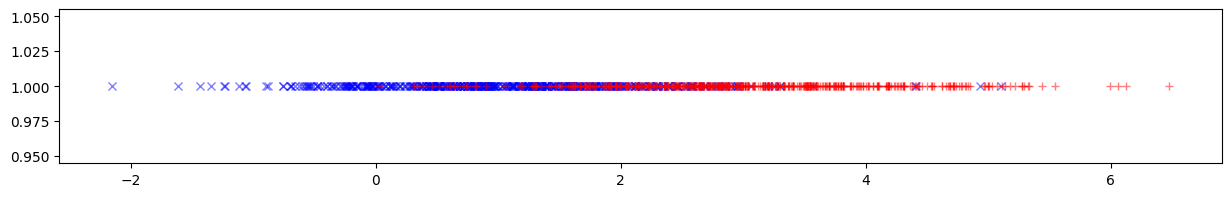

In [ ]:
# Here is what is looks like
plt.figure(figsize=(15, 2))
X_1_np = X_1.cpu().numpy()
X_2_np = X_2.cpu().numpy()
plt.plot(X_1_np, np.ones_like(X_1_np), 'x', color='blue', alpha=0.5);
plt.plot(X_2_np, np.ones_like(X_2_np), '+', color='red', alpha=0.5);

In [ ]:
# Let's create a weight tensor, as we would typically do in a formal neural network
W1 = torch.rand(1, 10, dtype=torch.float32, device=device)
W1 = (2.*W1 - 1.) # Uniform weights between -1 and 1
W1 = W1.requires_grad_() # Same as if we would have initialized the variable with requires_grad=True as argument

W2 = torch.rand(10, 2, dtype=torch.float32, device=device)
W2 = (2.*W2 - 1.)
W2 = W2.requires_grad_()

In [ ]:
# Feed forward part
def sigmoid_activation_function(inp):
    # You can add any arbitrary python functions and call them whenever
    # Pytorch autograd will still be able to compute the gradient
    # Here is an illustration of the sigmoid function
    # But normally, you'd use torch.nn.Sigmoid() which is faster
    return 1 / (1 + torch.exp(-inp))

hidden_output = sigmoid_activation_function(torch.matmul(X, W1))
output = sigmoid_activation_function(torch.matmul(hidden_output, W2))

In [ ]:
accuracy = torch.sum(torch.argmax(output, dim=1) == y.view(-1,)).float() / y.shape[0] * 100.
print("Pre training accuracy : %.2f %%" % accuracy)

Pre training accuracy : 50.00 %


In [ ]:
# Near 50% ! That may seem good, but keep in mind that for a two class problem,
# this is almost equivalent to a random classification
# We can look at the output tensor's statistics to understand why:
torch.mean(output, dim=0), torch.std(output, dim=0)

(tensor([0.6400, 0.4170], device='cuda:0', grad_fn=<MeanBackward1>),
 tensor([0.0403, 0.0216], device='cuda:0', grad_fn=<StdBackward0>))

In [ ]:
# Let's create a standard SGD in order to train these weights
optimizer = torch.optim.SGD((W1, W2,), lr=5e-1, momentum=0.9)

# And we'll iterate over some epochs
for i in range(1001):
    optimizer.zero_grad() # Reset the gradient in pytorch

    # We do forward propagation once again
    hidden_output = sigmoid_activation_function(torch.matmul(X, W1))
    output = sigmoid_activation_function(torch.matmul(hidden_output, W2))

    # We use the mean squared error as a loss function, we could also use torch.nn.MSELoss
    loss = torch.mean((oh_y - output) ** 2)

    loss.backward() # Compute the local loss for each layers
    optimizer.step() # Do a step of SGD
    if i % 100 == 0:
        print("Loss iteration %i : %.4f" % (i+1, loss.detach().cpu().numpy()))

Loss iteration 1 : 0.2430
Loss iteration 101 : 0.1170
Loss iteration 201 : 0.1170
Loss iteration 301 : 0.1169
Loss iteration 401 : 0.1169
Loss iteration 501 : 0.1169
Loss iteration 601 : 0.1169
Loss iteration 701 : 0.1169
Loss iteration 801 : 0.1169
Loss iteration 901 : 0.1169
Loss iteration 1001 : 0.1169


In [ ]:
hidden_output = sigmoid_activation_function(torch.matmul(X, W1))
output = sigmoid_activation_function(torch.matmul(hidden_output, W2))
accuracy = torch.sum(torch.argmax(output, dim=1) == y.view(-1,)).float() / y.shape[0] * 100.
print("Post training accuracy : %.2f %%" % accuracy)

Post training accuracy : 83.60 %


You can define your own gradients too, say you have a non differentiable function for example

Here is a good example of RELU, taken from [here](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html)

In [ ]:
class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

Let's re-create the weights so they aren't trained

In [ ]:
W1 = torch.rand(1, 6, dtype=torch.float32, device=device)
W1 = (2.*W1 - 1.)
W1 = W1.requires_grad_()

W2 = torch.rand(6, 4, dtype=torch.float32, device=device)
W2 = (2.*W2 - 1.)
W2 = W2.requires_grad_()

W3 = torch.rand(4, 2, dtype=torch.float32, device=device)
W3 = (2.*W3 - 1.)
W3 = W3.requires_grad_()

With our custom activation function, let's create our network.
Here we use the Mean Square Error (MSE) loss and the Adam optimizer algorithm from PyTorch.

Adam optimizer is kind of like the Stochastic Gradient Descent (SGD) algorithm but wiht an adaptive learning rate and more features making it more computationally efficient and give overall better performances than SGD.

More infos can be found [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).

In [ ]:
hidden_activation_fnct = MyReLU.apply
loss_fnct = torch.nn.MSELoss()
optimizer = torch.optim.Adam((W1, W2, W3), lr = 0.003)

for i in range(1,2000):
    optimizer.zero_grad() # Reset the gradient in pytorch

    # We do forward propagation once again
    # With our custom ReLU for the hidden layers
    hidden_output_1 = hidden_activation_fnct(torch.matmul(X, W1))
    hidden_output_2 = hidden_activation_fnct(torch.matmul(hidden_output_1, W2))
    output = sigmoid_activation_function(torch.matmul(hidden_output_2, W3))
    loss = loss_fnct(output, oh_y)

    loss.backward() # Compute the local loss for each layers
    optimizer.step() # Do a step of Adam
    if i % 200 == 0:
        print("Loss iteration %i : %.6f" % (i, loss.detach().cpu().numpy()))

hidden_output_1 = hidden_activation_fnct(torch.matmul(X, W1))
hidden_output_2 = hidden_activation_fnct(torch.matmul(hidden_output_1, W2))
output = sigmoid_activation_function(torch.matmul(hidden_output_2, W3))
accuracy = torch.sum(torch.argmax(output, dim=1) == y.view(-1,)).float() / y.shape[0] * 100.
print("Post training accuracy with ReLU : %.2f %%" % accuracy)

Loss iteration 200 : 0.184587
Loss iteration 400 : 0.183744
Loss iteration 600 : 0.183709
Loss iteration 800 : 0.183708
Loss iteration 1000 : 0.183708
Loss iteration 1200 : 0.183708
Loss iteration 1400 : 0.183708
Loss iteration 1600 : 0.183708
Loss iteration 1800 : 0.183708
Post training accuracy with ReLU : 83.60 %
